# Developing an AI application

Going forward, AI algorithms will be incorporated into more and more everyday applications. For example, you might want to include an image classifier in a smart phone app. To do this, you'd use a deep learning model trained on hundreds of thousands of images as part of the overall application architecture. A large part of software development in the future will be using these types of models as common parts of applications. 

In this project, you'll train an image classifier to recognize different species of flowers. You can imagine using something like this in a phone app that tells you the name of the flower your camera is looking at. In practice you'd train this classifier, then export it for use in your application. We'll be using [this dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) of 102 flower categories, you can see a few examples below. 

<img src='assets/Flowers.png' width=500px>

The project is broken down into multiple steps:

* Load and preprocess the image dataset
* Train the image classifier on your dataset
* Use the trained classifier to predict image content

We'll lead you through each part which you'll implement in Python.

When you've completed this project, you'll have an application that can be trained on any set of labeled images. Here your network will be learning about flowers and end up as a command line application. But, what you do with your new skills depends on your imagination and effort in building a dataset. For example, imagine an app where you take a picture of a car, it tells you what the make and model is, then looks up information about it. Go build your own dataset and make something new.

First up is importing the packages you'll need. It's good practice to keep all the imports at the beginning of your code. As you work through this notebook and find you need to import a package, make sure to add the import up here.

Please make sure if you are running this notebook in the workspace that you have chosen GPU rather than CPU mode.

In [1]:
# Imports here
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

import time
import json
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from collections import OrderedDict
import numpy as np


## Load the data

Here you'll use `torchvision` to load the data ([documentation](http://pytorch.org/docs/0.3.0/torchvision/index.html)). The data should be included alongside this notebook, otherwise you can [download it here](https://s3.amazonaws.com/content.udacity-data.com/nd089/flower_data.tar.gz). The dataset is split into three parts, training, validation, and testing. For the training, you'll want to apply transformations such as random scaling, cropping, and flipping. This will help the network generalize leading to better performance. You'll also need to make sure the input data is resized to 224x224 pixels as required by the pre-trained networks.

The validation and testing sets are used to measure the model's performance on data it hasn't seen yet. For this you don't want any scaling or rotation transformations, but you'll need to resize then crop the images to the appropriate size.

The pre-trained networks you'll use were trained on the ImageNet dataset where each color channel was normalized separately. For all three sets you'll need to normalize the means and standard deviations of the images to what the network expects. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`, calculated from the ImageNet images.  These values will shift each color channel to be centered at 0 and range from -1 to 1.
 

In [2]:
data_dir = 'flowers'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
test_dir = data_dir + '/test'

In [3]:
# TODO: Define your transforms for the training, validation, and testing sets
train_transforms = transforms.Compose([
    transforms.RandomRotation(degrees=50),
    transforms.RandomResizedCrop(size=224),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                         std=[0.229, 0.224, 0.225])
])

test_transforms = transforms.Compose([
    transforms.Resize(size=255),
    transforms.CenterCrop(size=224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                         std=[0.229, 0.224, 0.225])
])

valid_transforms = transforms.Compose([
    transforms.Resize(size=255),
    transforms.CenterCrop(size=224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                         std=[0.229, 0.224, 0.225])
])

# TODO: Load the datasets with ImageFolder
train_data = datasets.ImageFolder(train_dir, transform=train_transforms)
test_data = datasets.ImageFolder(test_dir, transform=test_transforms)
valid_data = datasets.ImageFolder(valid_dir, transform=valid_transforms)

# TODO: Using the image datasets and the trainforms, define the dataloaders
trainloader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
testloader = torch.utils.data.DataLoader(test_data, batch_size=64)
validloader = torch.utils.data.DataLoader(valid_data, batch_size=64)

### Label mapping

You'll also need to load in a mapping from category label to category name. You can find this in the file `cat_to_name.json`. It's a JSON object which you can read in with the [`json` module](https://docs.python.org/2/library/json.html). This will give you a dictionary mapping the integer encoded categories to the actual names of the flowers.

In [3]:


with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)

# Building and training the classifier

Now that the data is ready, it's time to build and train the classifier. As usual, you should use one of the pretrained models from `torchvision.models` to get the image features. Build and train a new feed-forward classifier using those features.

We're going to leave this part up to you. Refer to [the rubric](https://review.udacity.com/#!/rubrics/1663/view) for guidance on successfully completing this section. Things you'll need to do:

* Load a [pre-trained network](http://pytorch.org/docs/master/torchvision/models.html) (If you need a starting point, the VGG networks work great and are straightforward to use)
* Define a new, untrained feed-forward network as a classifier, using ReLU activations and dropout
* Train the classifier layers using backpropagation using the pre-trained network to get the features
* Track the loss and accuracy on the validation set to determine the best hyperparameters

We've left a cell open for you below, but use as many as you need. Our advice is to break the problem up into smaller parts you can run separately. Check that each part is doing what you expect, then move on to the next. You'll likely find that as you work through each part, you'll need to go back and modify your previous code. This is totally normal!

When training make sure you're updating only the weights of the feed-forward network. You should be able to get the validation accuracy above 70% if you build everything right. Make sure to try different hyperparameters (learning rate, units in the classifier, epochs, etc) to find the best model. Save those hyperparameters to use as default values in the next part of the project.

One last important tip if you're using the workspace to run your code: To avoid having your workspace disconnect during the long-running tasks in this notebook, please read in the earlier page in this lesson called Intro to GPU Workspaces about Keeping Your Session Active. You'll want to include code from the workspace_utils.py module.

In [66]:
# TODO: Build and train your network
# after few iterations I chose vgg19 as my pretrained model. This model gave a good result.
model = models.vgg19(pretrained=True)
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (17): ReLU(inplace)

In [79]:
# Freeze params so we don't backpropogate through them
for param in model.parameters():
    param.requires_grad = False

In [80]:
# Let's define our fully connected layer
# There are 25088 Input features in our fuully connected layer
# Since we have 102 classes of flowers  our output layer has 102 classes
# I used one hidden layer
# RELU as the activation function. RELU in general is quicker to train
# In order to train differnt parts of the network I used a dropout probablity for connections between 
#  - input to hidden layer (p=0.5)
#  - hidden layer to output (p=0.2)
# Output activation function is LogSoftMax, similar to the exercises , so in order to get actual
# probability valus we need to get exp. of the output.
classifier = nn.Sequential(OrderedDict([
    ('fc1', nn.Linear(25088, 4096)),
    ('relu1', nn.ReLU()),
    ('drop1', nn.Dropout(p=0.5)),
    ('fc2', nn.Linear(4096, 1024)),
    ('relu2', nn.ReLU()),
    ('drop2', nn.Dropout(p=0.2)),
    ('fc3', nn.Linear(1024, 102)),
    ('output', nn.LogSoftmax(dim=1))
]))

# replace pretrained model classifier with our classifier. 
model.classifier = classifier

# define an optimizer.
# Adam is a fair choice and in general quicker to train
optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)

# define criterion NLLLoss
# NegativeLikelihoodLogLoss + LogSoftmax ~ CrossEntropyLoss
# See: https://pytorch.org/docs/stable/nn.html#torch.nn.functional.binary_cross_entropy
criterion = nn.NLLLoss()

In [81]:
# Use GPU if it's available, owherwise use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [82]:
# The code here is basically taken from excercises in Pytorch Class 
# and adapted for the validation set. There is nothing much very different than what 
# we did in the lectures for training. 
# In each 5 training batches (64 x 5 images) we run the validation set and see the validation
# accuracy is increasing, and both training and validation loss is decreasing. 

# after few iterations I had an accuracy score ~79% with three epochs
# Possibly I may have had better accuracy score if I trained further as after 3 epochs
# both training and validation loss values are still decreasing, we were not yet 
# in overfitting region. But accuracy gains are ever decreasing and training was taking 
# quite long time even on GPU. 

model.to(device)

epochs = 3
steps = 0
running_loss = 0
print_every = 5
for epoch in range(epochs):
    for inputs, labels in trainloader:
        
        # Move input and label tensors to the default device
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        logps = model.forward(inputs)
        loss = criterion(logps, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        
        steps += 1
        if steps % print_every == 0:
            valid_loss = 0
            accuracy = 0
            model.eval()
            with torch.no_grad():
                for inputs, labels in validloader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    logps = model.forward(inputs)
                    batch_loss = criterion(logps, labels)
                    
                    valid_loss += batch_loss.item()
                    
                    # Calculate accuracy
                    ps = torch.exp(logps)
                    top_p, top_class = ps.topk(1, dim=1)
                    equals = top_class == labels.view(*top_class.shape)
                    accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
                    
            print(f"Epoch {epoch+1}/{epochs}.. "
                  f"Train loss: {running_loss/print_every:.3f}.. "
                  f"Validation loss: {valid_loss/len(testloader):.3f}.. "
                  f"Validation accuracy: {accuracy/len(validloader):.3f}")
            running_loss = 0
            model.train()

Epoch 1/3.. Train loss: 5.438.. Validation loss: 4.872.. Validation accuracy: 0.069
Epoch 1/3.. Train loss: 4.753.. Validation loss: 4.319.. Validation accuracy: 0.069
Epoch 1/3.. Train loss: 4.399.. Validation loss: 4.119.. Validation accuracy: 0.124
Epoch 1/3.. Train loss: 4.157.. Validation loss: 3.831.. Validation accuracy: 0.176
Epoch 1/3.. Train loss: 3.930.. Validation loss: 3.489.. Validation accuracy: 0.241
Epoch 1/3.. Train loss: 3.624.. Validation loss: 3.236.. Validation accuracy: 0.238
Epoch 1/3.. Train loss: 3.511.. Validation loss: 3.001.. Validation accuracy: 0.288
Epoch 1/3.. Train loss: 3.254.. Validation loss: 2.728.. Validation accuracy: 0.332
Epoch 1/3.. Train loss: 3.141.. Validation loss: 2.492.. Validation accuracy: 0.405
Epoch 1/3.. Train loss: 3.046.. Validation loss: 2.437.. Validation accuracy: 0.403
Epoch 1/3.. Train loss: 2.916.. Validation loss: 2.188.. Validation accuracy: 0.471
Epoch 1/3.. Train loss: 2.716.. Validation loss: 2.132.. Validation accuracy

## Testing your network

It's good practice to test your trained network on test data, images the network has never seen either in training or validation. This will give you a good estimate for the model's performance on completely new images. Run the test images through the network and measure the accuracy, the same way you did validation. You should be able to reach around 70% accuracy on the test set if the model has been trained well.

In [83]:
# TODO: Do validation on the test set


test_loss = 0
accuracy = 0
model.eval()

with torch.no_grad():
    for inputs, labels in testloader:
        
        # Move inputs and labels to GPU (if enabled)
        inputs, labels = inputs.to(device), labels.to(device)
        
        # do a forward run and calculate error
        logps = model.forward(inputs)
        batch_loss = criterion(logps, labels)
                    
        test_loss += batch_loss.item()
                    
        # Calculate accuracy
        ps = torch.exp(logps)
        top_p, top_class = ps.topk(1, dim=1)
        equals = top_class == labels.view(*top_class.shape)
        accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
                    
    print(f"Test loss: {test_loss/len(testloader):.3f}.. "
          f"Test accuracy: {accuracy/len(testloader):.3f}")
    

Test loss: 0.915.. Test accuracy: 0.744


## Save the checkpoint

Now that your network is trained, save the model so you can load it later for making predictions. You probably want to save other things such as the mapping of classes to indices which you get from one of the image datasets: `image_datasets['train'].class_to_idx`. You can attach this to the model as an attribute which makes inference easier later on.

```model.class_to_idx = image_datasets['train'].class_to_idx```

Remember that you'll want to completely rebuild the model later so you can use it for inference. Make sure to include any information you need in the checkpoint. If you want to load the model and keep training, you'll want to save the number of epochs as well as the optimizer state, `optimizer.state_dict`. You'll likely want to use this trained model in the next part of the project, so best to save it now.

In [88]:
# TODO: Save the checkpoint 

# I save few parameters, such as model classifier, model_state_dict and class_to_idx to
# rebuild the model later, 
# I also decided to save epoch and optimizer_state_dict, so if I want to futher train the model
# this way I could continue training. 

checkpoint = {
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'class_to_idx': train_data.class_to_idx,
    'classifier': model.classifier,
}

torch.save(checkpoint, 'trained_model_vgg19.pth')

## Loading the checkpoint

At this point it's good to write a function that can load a checkpoint and rebuild the model. That way you can come back to this project and keep working on it without having to retrain the network.

In [89]:
# TODO: Write a function that loads a checkpoint and rebuilds the model
# train_components is a boolean argument and by default is set to False
# This means load only model, but not training related data such as epochs, optimizer with state, 
# and loss criterion 

def load_my_trained_model(model_path='trained_model_vgg19.pth', train_components=False):
    """
        Load the model I trained for the task
        It uses features from pretrained model of vgg19 and was trained 
        with a custom fully connected layer (classifier)
        it also returns `epoch`, `optimizer` and `criterion`
        if we need to retrain the model further. 
    """
    
    # load the saved model dict 
    checkpoint = torch.load(model_path)
    
    # We use the features from VGG19 and replace fully connected layer
    # and turn off updating weights. 
    model = models.vgg19(pretrained=True)
    for param in model.parameters():
            param.requires_grad = False
    
    # replace fully connected layer with our loaded model
    model.classifier = checkpoint['classifier']
    
    # Class mapping
    model.class_to_idx =  checkpoint['class_to_idx']
    
    # Load weights for the model
    model.load_state_dict(checkpoint['model_state_dict'])
    
    # If the user only asks for model, not for other params like optimizer, epoch etc..
    # return model, else return a tuple of model, epoch, optimizer, criterion
    if not train_components:
        return model
        
    # create optimizer and load state dict
    optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    
    # criterion used for training
    criterion = nn.NLLLoss()
    
    epoch = checkpoint['epoch']
    
    return model, epoch, optimizer, criterion 

In [92]:
model = load_my_trained_model()

In [93]:
# test model on test date to see if model has been loaded successfully. 
# It should give the same result we had previously in test section. This is a sanity check for `load_my_trained_model` function

model.to(device)
test_loss = 0
accuracy = 0
model.eval()

with torch.no_grad():
    for inputs, labels in testloader:
        
        # Move inputs and labels to GPU (if enabled)
        inputs, labels = inputs.to(device), labels.to(device)
        
        # do a forward run and calculate error
        logps = model.forward(inputs)
        batch_loss = criterion(logps, labels)
                    
        test_loss += batch_loss.item()
                    
        # Calculate accuracy
        ps = torch.exp(logps)
        top_p, top_class = ps.topk(1, dim=1)
        equals = top_class == labels.view(*top_class.shape)
        accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
                    
    print(f"Test loss: {test_loss/len(testloader):.3f}.. "
          f"Test accuracy: {accuracy/len(testloader):.3f}")

Test loss: 0.915.. Test accuracy: 0.744


# Inference for classification

Now you'll write a function to use a trained network for inference. That is, you'll pass an image into the network and predict the class of the flower in the image. Write a function called `predict` that takes an image and a model, then returns the top $K$ most likely classes along with the probabilities. It should look like 

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

First you'll need to handle processing the input image such that it can be used in your network. 

## Image Preprocessing

You'll want to use `PIL` to load the image ([documentation](https://pillow.readthedocs.io/en/latest/reference/Image.html)). It's best to write a function that preprocesses the image so it can be used as input for the model. This function should process the images in the same manner used for training. 

First, resize the images where the shortest side is 256 pixels, keeping the aspect ratio. This can be done with the [`thumbnail`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) or [`resize`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) methods. Then you'll need to crop out the center 224x224 portion of the image.

Color channels of images are typically encoded as integers 0-255, but the model expected floats 0-1. You'll need to convert the values. It's easiest with a Numpy array, which you can get from a PIL image like so `np_image = np.array(pil_image)`.

As before, the network expects the images to be normalized in a specific way. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`. You'll want to subtract the means from each color channel, then divide by the standard deviation. 

And finally, PyTorch expects the color channel to be the first dimension but it's the third dimension in the PIL image and Numpy array. You can reorder dimensions using [`ndarray.transpose`](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.ndarray.transpose.html). The color channel needs to be first and retain the order of the other two dimensions.

In [94]:
# I believe we can make use of torchvisions transform classes to preprocess the Image 
# as we did previously at the beginning of notebook. Therefore I'll slightly diverge from
# the guidance above and do transformations using torchvision and the convert results to numpy

from PIL import Image
def process_image(image):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''
    
    # Assuming image is a PIL.Image object, let's not modify the source image,
    # but create a copy of it, so function has no side effects
    img = image.copy()
    
    # we can make use of torchvision.transform
    # Define transfromations
    
    transform = transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406], 
            std=[0.229, 0.224, 0.225])
    ])
    
    # Note that transform variable defined above is now actually a callable, 
    # classes like transforms.Compose implements `def __call__(self, img):` 
    # Therefore we can use PIL Image as an input to transform callable.
    # Apply transform to PIL image, it returns a tensor
    img = transform(img)
    
    # convert tensor to numpy array and return
    return img.numpy()

    

To check your work, the function below converts a PyTorch tensor and displays it in the notebook. If your `process_image` function works, running the output through this function should return the original image (except for the cropped out portions).

In [95]:
# imshow was given below had a keyword argument of title however it wasn't implemented in
# the function, so I added two lines to actually show title when imshow is called with title argument

def imshow(image, ax=None, title=None):
    if ax is None:
        fig, ax = plt.subplots()
        
    if title:
        plt.set_title(title)
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

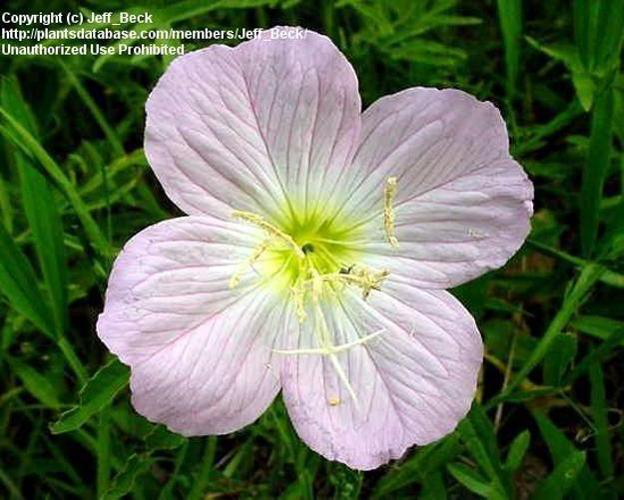

In [96]:
# Let's test my process_image function

# Read an image from validation set 
im = Image.open("flowers/valid/1/image_06755.jpg")

# show original image
im

Processed image dimentions as Numpy array is: (3, 224, 224)


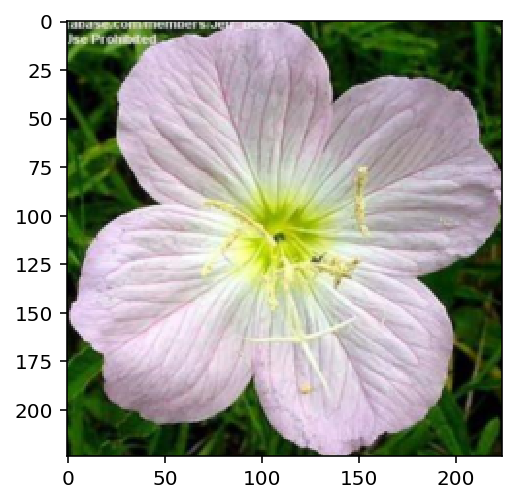

In [100]:
# Convert to numpy array using process_image function
processed = process_image(image=im)

print("Processed image dimentions as Numpy array is:", processed.shape)

# Now using imshow convert from numpy to normal image and display
imshow(processed)


## Class Prediction

Once you can get images in the correct format, it's time to write a function for making predictions with your model. A common practice is to predict the top 5 or so (usually called top-$K$) most probable classes. You'll want to calculate the class probabilities then find the $K$ largest values.

To get the top $K$ largest values in a tensor use [`x.topk(k)`](http://pytorch.org/docs/master/torch.html#torch.topk). This method returns both the highest `k` probabilities and the indices of those probabilities corresponding to the classes. You need to convert from these indices to the actual class labels using `class_to_idx` which hopefully you added to the model or from an `ImageFolder` you used to load the data ([see here](#Save-the-checkpoint)). Make sure to invert the dictionary so you get a mapping from index to class as well.

Again, this method should take a path to an image and a model checkpoint, then return the probabilities and classes.

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

In [121]:
# Slightly diverging from the model above predict function below returns actual flower class names, not numbers

def predict(image_path, model, topk=5):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    '''
    
    # TODO: Implement the code to predict the class from an image file
    
    image = Image.open(image_path)
    processed = process_image(image)
    
    # Expand numpy array dimention and convert to tensor
    processed  = np.expand_dims(processed,axis=0)
    X = torch.from_numpy(processed)
    
    # Use GPU if it's available
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # move model to device and set to eval mode
    model.to(device)
    model.eval()
    
    # Run a forward pass and predict classes  
    with torch.no_grad():
        
        # Move inputs to device(GPU)
        X = X.to(device)

        logps = model.forward(X)
        ps = torch.exp(logps)
        probs, classes = ps.topk(topk, dim=1)
    
    # Convert Tensor to numpy array 
    if probs.device.type == 'cuda':
        probs = probs.data.cpu().numpy().squeeze()
        classes = classes.data.cpu().numpy().squeeze()
    else:
        probs = probs.data.numpy().squeeze()
        classes = classes.data.numpy().squeeze()
        
    # Convert labels to actual flower names
    reverse_dict = dict()
    for k, v in model.class_to_idx.items():
        reverse_dict[v] = cat_to_name[k]
        
    classes = [reverse_dict[elem] for elem in classes]
    
    return probs.tolist(), classes
    

## Sanity Checking

Now that you can use a trained model for predictions, check to make sure it makes sense. Even if the testing accuracy is high, it's always good to check that there aren't obvious bugs. Use `matplotlib` to plot the probabilities for the top 5 classes as a bar graph, along with the input image. It should look like this:

<img src='assets/inference_example.png' width=300px>

You can convert from the class integer encoding to actual flower names with the `cat_to_name.json` file (should have been loaded earlier in the notebook). To show a PyTorch tensor as an image, use the `imshow` function defined above.

In [149]:
def sanity_check(image_path, topk=5,):
    
    # In our case correct label for image is hidden in image path 
    # for example image path: flowers/test/19/image_06175.jpg
    # then cat_to_name[19] would give the actual label for the flower
    label = image_path.split('/')[2]
    correct_class = cat_to_name[label]

    # Predict image 
    probs, classes = predict(image_path, model, topk=topk)
    
    # plot the flower and probabilities
    fig, (ax1, ax2) = plt.subplots(figsize=(3,6), nrows=2)
    
    # Plot the actual flower image with actual class name
    image = Image.open(image_path)
    ax1.imshow(image)
    ax1.set_title(correct_class)
    
    # Plot a barplot shows the class prediction and 
    # probability values attached
    ax2.barh(np.arange(5), probs)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(5))
    ax2.set_yticklabels(classes, size='small')
    


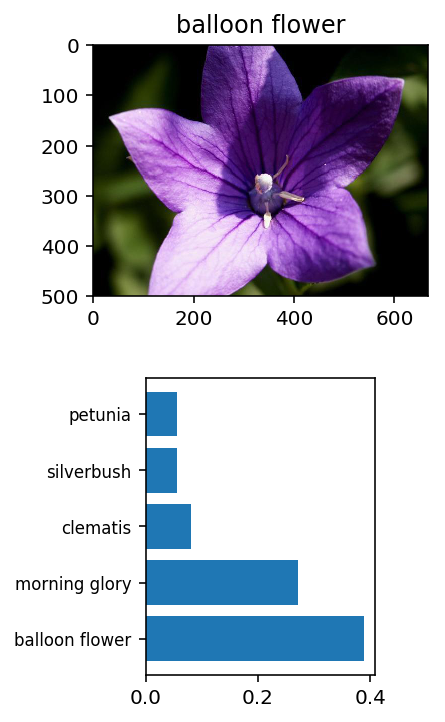

In [150]:
sanity_check("flowers/test/19/image_06175.jpg")